## Análise de Sinais com Transformada Wavelet

**Objetivo:** Utilizar a Transformada Wavelet para analisar sinais de vibração não estacionários e detectar falhas transientes em um motor.

**Contexto:** No notebook anterior, vimos como a FFT é poderosa para identificar frequências constantes em um sinal. No entanto, sua principal limitação é que ela nos diz **quais** frequências existem, mas não **quando** elas ocorreram. A FFT analisa o sinal inteiro de uma vez, perdendo toda a informação temporal.

Muitas falhas mecânicas não são constantes. Elas podem ser:
- **Transientes:** Ocorrem como um pico ou impacto de curta duração (ex: uma trinca em um dente de engrenagem que causa um "clique" a cada rotação).
- **Intermitentes:** Aparecem e desaparecem.
- **Variáveis:** A frequência da falha muda com a velocidade da máquina (ex: durante a partida ou parada).

É aqui que a **Transformada Wavelet** se destaca. Ela é uma ferramenta de análise de **tempo-frequência**, funcionando como um microscópio que podemos deslizar ao longo do sinal para ver quais frequências estão presentes em cada instante de tempo.

> **Analogia:** Se um sinal é uma partitura musical, a **FFT** te dá uma lista de todas as notas usadas na música. A **Transformada Wavelet** te dá a própria **partitura**, mostrando qual nota foi tocada em que momento.

### Configuração e Importação de Bibliotecas

In [1]:
# Instale a biblioteca se ainda não tiver
# !pip install PyWavelets

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt  # Biblioteca PyWavelets
from scipy.fft import fft, fftfreq

# Configurações de visualização
plt.rcParams["figure.figsize"] = (16, 5)

### Simulação de um Sinal Não Estacionário

Para demonstrar o poder das wavelets, vamos criar um sinal que a FFT teria dificuldade em interpretar. O sinal representará um motor operando normalmente a 30 Hz, mas que sofre um **evento de vibração transiente e de alta frequência** no meio de sua operação. Isso pode simular um impacto, uma falha momentânea de lubrificação ou o contato entre partes metálicas.

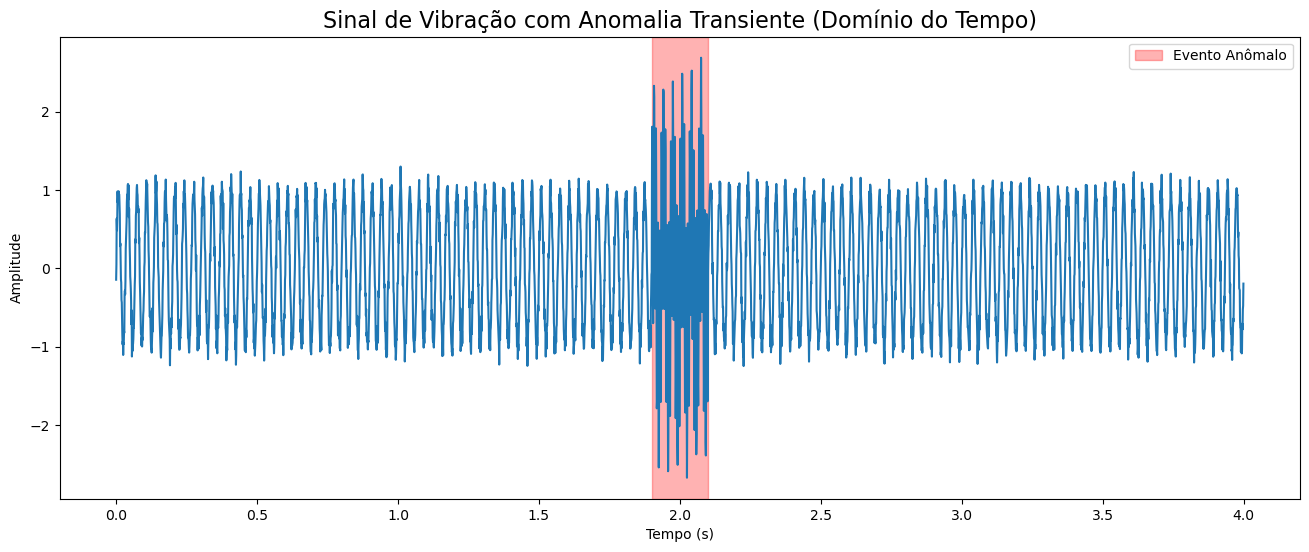

In [2]:
# Parâmetros da Simulação
SAMPLING_RATE = 1000  # Hz
DURATION = 4  # Segundos
N_SAMPLES = SAMPLING_RATE * DURATION
t = np.linspace(0.0, DURATION, N_SAMPLES, endpoint=False)

# Frequência de rotação normal do motor
F_MOTOR = 30  # Hz

# Sinal base (motor saudável)
signal_base = np.sin(2 * np.pi * F_MOTOR * t)

# Cria o evento transiente (anomalia)
F_ANOMALY = 150  # Hz (alta frequência)
anomaly = np.sin(2 * np.pi * F_ANOMALY * t)

# Cria uma "janela" para o evento transiente, para que ele dure apenas um curto período
transient_window = np.zeros(N_SAMPLES)
start_event = int(1.9 * SAMPLING_RATE)  # Começa em 1.9s
end_event = int(2.1 * SAMPLING_RATE)  # Termina em 2.1s
transient_window[start_event:end_event] = (
    1  # Janela Gaussiana seria mais suave, mas a quadrada é mais clara para o exemplo
)

# Sinal final com a anomalia transiente
signal_nonstationary = (
    signal_base + (anomaly * transient_window) * 1.5 + np.random.randn(N_SAMPLES) * 0.1
)

# --- Visualização no Domínio do Tempo ---
plt.figure(figsize=(16, 6))
plt.plot(t, signal_nonstationary)
plt.title("Sinal de Vibração com Anomalia Transiente (Domínio do Tempo)", fontsize=16)
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
# Destaca a região do evento
plt.axvspan(1.9, 2.1, color="red", alpha=0.3, label="Evento Anômalo")
plt.legend()

### Análise com a Ferramenta "Antiga": FFT

Vamos ver o que a FFT nos diz sobre este sinal. Ela conseguirá detectar a frequência da anomalia? E a que custo?

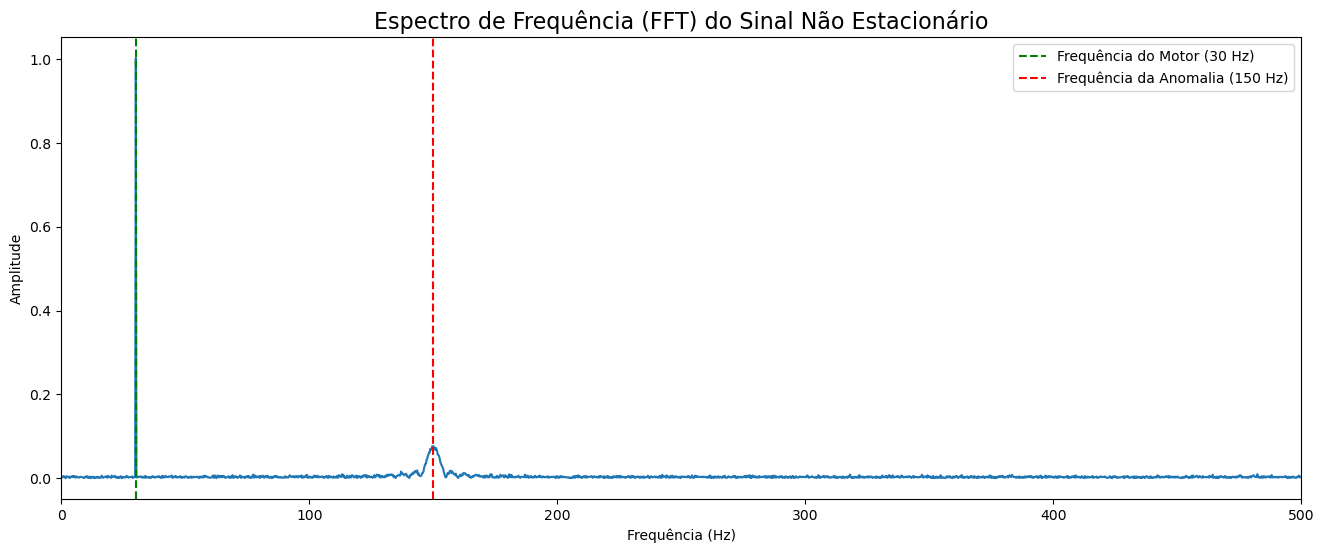

In [3]:
# Calcula a FFT
yf = fft(signal_nonstationary)
xf = fftfreq(N_SAMPLES, 1 / SAMPLING_RATE)

# Pega apenas a parte positiva do espectro e normaliza
mask = xf >= 0
xf_pos = xf[mask]
yf_pos = 2.0 / N_SAMPLES * np.abs(yf[mask])

# Plota o Espectro de Frequência
plt.figure(figsize=(16, 6))
plt.plot(xf_pos, yf_pos)
plt.title("Espectro de Frequência (FFT) do Sinal Não Estacionário", fontsize=16)
plt.xlabel("Frequência (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, SAMPLING_RATE / 2)
plt.axvline(
    F_MOTOR, color="green", linestyle="--", label=f"Frequência do Motor ({F_MOTOR} Hz)"
)
plt.axvline(
    F_ANOMALY,
    color="red",
    linestyle="--",
    label=f"Frequência da Anomalia ({F_ANOMALY} Hz)",
)
plt.grid(False)
plt.legend()

**Diagnóstico com FFT:**

A FFT detectou corretamente as duas frequências principais: um pico forte em 30 Hz (operação normal) e um pico menor em 150 Hz (anomalia). 

**A Informação Perdida:** O gráfico nos diz **que** a frequência de 150 Hz está presente, mas não nos dá **nenhuma pista** de que ela ocorreu apenas por 0.2 segundos. A energia desse evento transiente foi "espalhada" por toda a duração do sinal. Um operador olhando para isso poderia pensar que há um problema contínuo de 150 Hz, quando na verdade foi um evento isolado.

### Análise com a Ferramenta Certa: Transformada Wavelet

Agora, vamos aplicar a **Transformada Wavelet Contínua (CWT)**. O resultado não é um gráfico 1D, mas sim um **escalograma** 2D, que é um mapa de tempo-frequência. 

- **Eixo X:** Tempo
- **Eixo Y:** Frequência (ou Escala)
- **Cor:** Intensidade daquela frequência naquele instante de tempo

/home/thiag/GitHub/studies-industrial_processes/env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


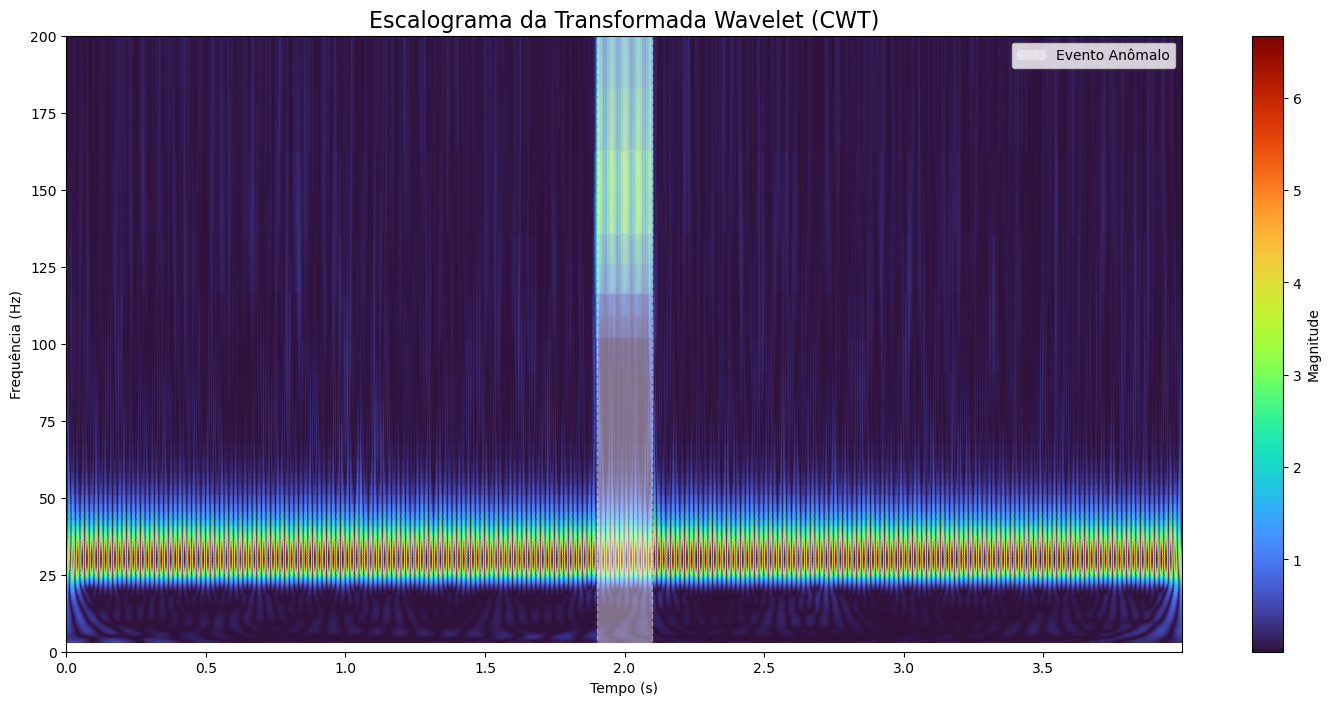

In [4]:
# Define a wavelet a ser usada (Morlet é uma boa escolha para análise de oscilações)
wavelet_name = "morl"

# Define as escalas para a análise. Escala é (inversamente) relacionada à frequência.
# Vamos criar uma faixa de escalas para cobrir nossas frequências de interesse.
scales = np.arange(1, 256)

# Calcula a Transformada Wavelet Contínua (CWT)
coefficients, frequencies = pywt.cwt(
    signal_nonstationary, scales, wavelet_name, 1 / SAMPLING_RATE
)

# --- Visualização do Escalograma (Tempo-Frequência) ---
plt.figure(figsize=(18, 8))
plt.pcolormesh(t, frequencies, np.abs(coefficients), cmap="turbo", shading="gouraud")
plt.title("Escalograma da Transformada Wavelet (CWT)", fontsize=16)
plt.xlabel("Tempo (s)")
plt.ylabel("Frequência (Hz)")
plt.colorbar(label="Magnitude")
# Destaca a região do evento para comparação
plt.axvspan(1.9, 2.1, color="white", alpha=0.4, linestyle="--", label="Evento Anômalo")
plt.legend()
plt.ylim(0, 200)  # Foco na nossa faixa de interesse
plt.show()

### Diagnóstico com a Transformada Wavelet

**Este é o "momento Eureka"!** O escalograma nos dá uma visão completa da história do sinal:

1.  **Operação Normal:** Vemos uma linha horizontal contínua e forte na marca de **30 Hz**. Isso nos diz que a frequência de operação do motor esteve presente e constante durante todo o tempo, como esperado.

2.  **Detecção do Evento Anômalo:** Exatamente entre 1.9 e 2.1 segundos, vemos uma "ilha" de alta energia (cor amarela/vermelha) centrada na frequência de **150 Hz**. 

**Diagnóstico Completo:** A análise wavelet não apenas nos diz que as frequências de 30 Hz e 150 Hz existiram, mas nos mostra precisamente que a de 30 Hz foi contínua e a de 150 Hz foi um **evento transiente, localizado e de curta duração**. Um engenheiro de manutenção, ao ver isso, saberia que não se trata de uma falha contínua como desalinhamento, mas sim de um evento de impacto, que pode indicar uma trinca, folga excessiva ou um problema de lubrificação momentâneo.

### Conclusão

Enquanto a FFT é uma ferramenta indispensável para analisar sinais estacionários, a **Transformada Wavelet** é a solução superior para os desafios da manutenção preditiva no mundo real, onde os sinais são frequentemente não estacionários.

- **Poder de Análise:** A capacidade de localizar eventos tanto no tempo quanto na frequência permite um diagnóstico muito mais preciso e detalhado da saúde de um equipamento.
- **Aplicações:** A análise wavelet é ideal para:
    - Detectar falhas de impacto (trincas em engrenagens, defeitos em rolamentos).
    - Analisar a partida (run-up) e parada (run-down) de máquinas, onde a velocidade e as frequências de vibração mudam constantemente.
    - Identificar falhas intermitentes que poderiam ser perdidas pela média da FFT.

A incorporação da Transformada Wavelet no arsenal de um analista de dados ou engenheiro de confiabilidade abre a porta para uma detecção de falhas mais precoce, robusta e inteligente.